In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
class CellState(object):
    def __init__(self, Ncell, dx, rho, momentum, energy, gamma=5./3.):
        self.rho = rho
        self.momentum = momentum
        self.energy = energy

        self.Ncell = Ncell

        self.dx = dx

        self.gamma = gamma

        self._allocate_cell_faces()

    @property
    def vel(self):
        """Compute the velocity on demand."""
        return self.momentum / self.rho

    @property
    def pressure(self):
        """Compute the pressure based on the energy and kinetic energy."""
        kinetic = 0.5 * self.rho * self.vel ** 2
        return (self.energy - kinetic) * (self.gamma - 1.0)

    @property
    def sound_speed(self):
        """Compute the sound speed from the pressure and density."""
        return np.sqrt(self.gamma * self.pressure / self.rho)
    
    def _allocate_cell_faces(self):
        """Allocates arrays for fluid properties at cell faces. rho_face[i,0] is the right face of cell i and rho_face[i,1] is the left face of cell i+1."""
        self.Nface         = self.Ncell
        self.rho_face      = np.zeros((self.Nface, 2))
        self.momentum_face = np.zeros((self.Nface, 2))
        self.energy_face   = np.zeros((self.Nface, 2))

        # Allocate also for fluxes
        self.flux_rho     = np.zeros(self.Nface)
        self.flux_momentum = np.zeros(self.Nface)
        self.flux_energy   = np.zeros(self.Nface)


In [47]:
class HydroSolver(object):
    def __init__(self, cellstate, t0=0.0):
        self.cellstate = cellstate
        self.t0 = t0
        self.t = self.t0

    def run(self, t1, dt):
        """Run the simulation until time t1 with a timestep of dt."""
        assert t1 > self.t

        while self.t < t1:
            dt = min(dt, t1 - self.t)
            self._step(dt)
        
    def _step(self, dt):
        self._reconstruction()
        self._compute_fluxes()
        self._apply_fluxes(dt)
        self.t += dt

    def _reconstruction(self):
        """Reconstruct the state at the cell interfaces. For now, simple piecewise."""
        for i in range(self.cellstate.Nface):
            self.cellstate.rho_face[i,0] = self.cellstate.rho[i]
            self.cellstate.momentum_face[i,0] = self.cellstate.momentum[i]
            self.cellstate.energy_face[i,0] = self.cellstate.energy[i]

            ip1 = (i+1) % self.cellstate.Ncell
            self.cellstate.rho_face[i,1] = self.cellstate.rho[ip1]
            self.cellstate.momentum_face[i,1] = self.cellstate.momentum[ip1]
            self.cellstate.energy_face[i,1] = self.cellstate.energy[ip1]
    
    def _compute_fluxes(self):
        for i in range(self.cellstate.Nface):
            # pull out face states
            rho_L = self.cellstate.rho_face[i,0]
            rho_R = self.cellstate.rho_face[i,1]
            momentum_L = self.cellstate.momentum_face[i,0]
            momentum_R = self.cellstate.momentum_face[i,1]
            energy_L = self.cellstate.energy_face[i,0]
            energy_R = self.cellstate.energy_face[i,1]

            # compute fluxes
            flux_rho, flux_momentum, flux_energy = self._rusanov_flux(rho_L, rho_R, momentum_L, momentum_R, energy_L, energy_R)
            self.cellstate.flux_rho[i] = flux_rho
            self.cellstate.flux_momentum[i] = flux_momentum
            self.cellstate.flux_energy[i] = flux_energy
    
    def _apply_fluxes(self, dt):
        for i in range(self.cellstate.Nface):
            # recall that face i connects cell i and i+1
            ip1 = (i+1) % self.cellstate.Ncell
            dx = self.cellstate.dx
            self.cellstate.rho[i] -= (dt/dx) * self.cellstate.flux_rho[i]
            self.cellstate.rho[ip1] += (dt/dx) * self.cellstate.flux_rho[i]

            self.cellstate.momentum[i] -= (dt/dx) * self.cellstate.flux_momentum[i]
            self.cellstate.momentum[ip1] += (dt/dx) * self.cellstate.flux_momentum[i]

            self.cellstate.energy[i] -= (dt/dx) * self.cellstate.flux_energy[i]
            self.cellstate.energy[ip1] += (dt/dx) * self.cellstate.flux_energy[i]

    def _Euler_flux(self, rho, momentum, energy):
        vel = momentum / rho
        kinetic_energy = 0.5 * rho * vel ** 2
        pressure = (energy - kinetic_energy) * (self.cellstate.gamma - 1.0)

        flux_rho = rho * vel
        flux_momentum = momentum * vel + pressure
        flux_energy = (energy + pressure) * vel
        return flux_rho, flux_momentum, flux_energy

    def _rusanov_flux(self, rho_L, rho_R, momentum_L, momentum_R, energy_L, energy_R):
        flux_rho_L, flux_momentum_L, flux_energy_L = self._Euler_flux(rho_L, momentum_L, energy_L)
        flux_rho_R, flux_momentum_R, flux_energy_R = self._Euler_flux(rho_R, momentum_R, energy_R)

        # compute sound speeds for face states
        vel_L = momentum_L / rho_L
        kinetic_energy_L = 0.5 * rho_L * vel_L ** 2
        pressure_L = (energy_L - kinetic_energy_L) * (self.cellstate.gamma - 1.0)
        cs_L = np.sqrt(self.cellstate.gamma * pressure_L / rho_L)

        vel_R = momentum_R / rho_R
        kinetic_energy_R = 0.5 * rho_R * vel_R ** 2
        pressure_R = (energy_R - kinetic_energy_R) * (self.cellstate.gamma - 1.0)
        cs_R = np.sqrt(self.cellstate.gamma * pressure_R / rho_R)

        # compute maximum wave speed at the interfaces
        alpha = max(abs(vel_L)+cs_L, abs(vel_R)+cs_R)

        flux_rho = 0.5 * (flux_rho_L + flux_rho_R) - 0.5 * alpha * (rho_R - rho_L)
        flux_momentum = 0.5 * (flux_momentum_L + flux_momentum_R) - 0.5 * alpha * (momentum_R - momentum_L)
        flux_energy = 0.5 * (flux_energy_L + flux_energy_R) - 0.5 * alpha * (energy_R - energy_L)
        return flux_rho, flux_momentum, flux_energy


In [41]:
Ncell = 100
dx = 1.0 / Ncell
rho = np.full(Ncell, 1.)
momentum = np.full(Ncell, 0.1)
energy = np.full(Ncell, 0.1)
cellstate = CellState(Ncell, dx, rho, momentum, energy)

hydrosolver = HydroSolver(cellstate)

In [42]:
hydrosolver.cellstate.rho

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [43]:
hydrosolver.run(1, 0.001)

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011000000000000003
0.012000000000000004
0.013000000000000005
0.014000000000000005
0.015000000000000006
0.016000000000000007
0.017000000000000008
0.01800000000000001
0.01900000000000001
0.02000000000000001
0.02100000000000001
0.022000000000000013
0.023000000000000013
0.024000000000000014
0.025000000000000015
0.026000000000000016
0.027000000000000017
0.028000000000000018
0.02900000000000002
0.03000000000000002
0.03100000000000002
0.03200000000000002
0.03300000000000002
0.03400000000000002
0.035000000000000024
0.036000000000000025
0.037000000000000026
0.03800000000000003
0.03900000000000003
0.04000000000000003
0.04100000000000003
0.04200000000000003
0.04300000000000003
0.04400000000000003
0.04500000000000003
0.046000000000000034
0.047000000000000035
0.048000000000000036
0.04900000000000004
0.05000000000000004
0.05100000000000004
0.05200000000000004
0.05300000000000004
0.05400000000000004
0.0550

In [66]:
Ncell = 100
dx = 1.0 / Ncell
rho = np.full(Ncell, 1.)
momentum = np.full(Ncell, 0.1)
energy = np.full(Ncell, 0.1)

rho[0] = 100.

cellstate = CellState(Ncell, dx, rho, momentum, energy)

hydrosolver = HydroSolver(cellstate)
hydrosolver.run(1, 0.001)

In [67]:
print(hydrosolver.cellstate.rho[0])

8.383396909376453


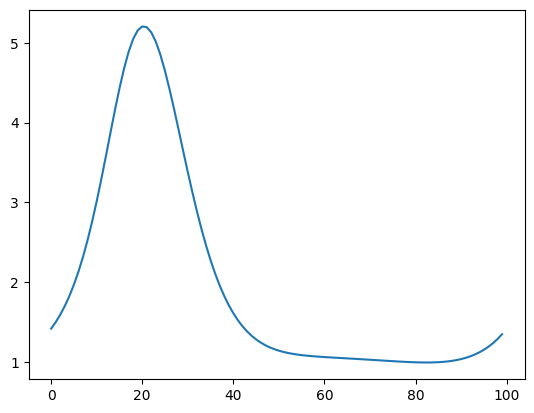

In [59]:
plt.plot(hydrosolver.cellstate.rho)

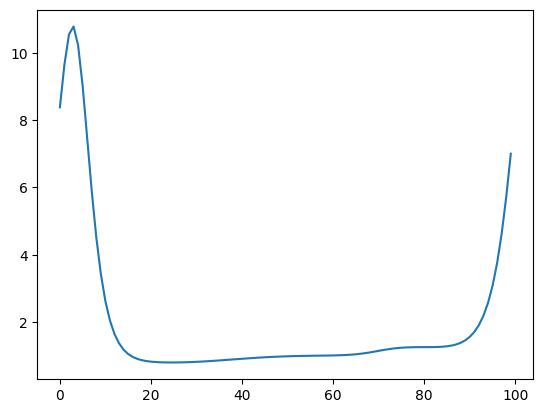

In [50]:
plt.plot(cellstate.rho)